In [5]:
import pandas as pd
import numpy as np
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
import os
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from tqdm import tqdm


os.environ["TOKENIZERS_PARALLELISM"] = "true"

/home/data/sarmad/sicss24/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [186]:
df = pd.read_csv('parenting_bigger_set.csv', low_memory=False)
# def convert_utc_to_day_level(utc):
#     return pd.to_datetime(utc, unit='s').strftime('%Y-%m-%d')
# df['created_utc'] = pd.to_datetime(df['created_utc'], unit='s').apply(convert_utc_to_day_level)
df = df[['title', 'selftext', 'link_flair_text', 'score', 'ups', 'downs', 'num_comments', 'created_utc']]
df = df[df['created_utc'] != 'self']
df = df.dropna(subset=['link_flair_text'])

In [187]:
# drop all values which are not in in UTC format
df['created_utc'] = pd.to_datetime(df['created_utc'], unit='s')
# filter the date to be greater than 2018
df = df[df['created_utc']>='2018-01-01']

In [188]:
# whats tha max and min date
max_date = df['created_utc'].max()
min_date = df['created_utc'].min()
print(f"Max date: {max_date}, Min date: {min_date}")
df

Max date: 2022-12-31 23:37:05, Min date: 2018-01-01 00:02:08


title  \
109578  [UPDATE] HELP. Wife died. How to tell my 2yo M...   
109581                               Trouble with napping   
109582                                     My amazing son   
109587  You know your a parent when your comforted by ...   
109589             How do I deal with a bossy 3 year old?   
...                                                   ...   
338255         Help with expectations for picky eater....   
338256                                        Feeling bad   
338257  Someone who isn't a parent, just seeking some ...   
338258                                            Daycare   
338259                       Teen/preteen boys’ sleepover   

                                                 selftext  \
109578  [See original post](https://www.reddit.com/r/P...   
109581  Hello all! I was hoping for some advice or tip...   
109582                                          [removed]   
109587                                          [removed]   
109589  My daughter is SO bossy.   She'll ask me to si...   
...                                                   ...   
338255  Ok, so parents of picky eaters, I need some ad...   
338256  I am in so much guilt for not celebrating my y...   
338257                                          [removed]   
338258  I want to preface this by saying that I unders...   
338259                                          [deleted]   

             link_flair_text   score  ups  downs num_comments  \
109578                Update  1336.0  NaN    NaN           91   
109581                Infant     3.0  NaN    NaN            3   
109582          Co-parenting     5.0  NaN    NaN            0   
109587                Humour     1.0  NaN    NaN            0   
109589                Advice     7.0  NaN    NaN           12   
...                      ...     ...  ...    ...          ...   
338255  Teenager 13-19 Years   121.0  NaN    NaN          123   
338256     Toddler 1-3 Years     0.0  NaN    NaN            7   
338257         Miscellaneous     0.0  NaN    NaN            6   
338258     Toddler 1-3 Years     0.0  NaN    NaN           10   
338259  Teenager 13-19 Years     9.0  NaN    NaN           43   

               created_utc  
109578 2018-01-01 00:02:08  
109581 2018-01-01 01:42:36  
109582 2018-01-01 01:45:29  
109587 2018-01-01 02:57:06  
109589 2018-01-01 03:51:51  
...                    ...  
338255 2022-12-31 23:17:04  
338256 2022-12-31 23:22:50  
338257 2022-12-31 23:23:12  
338258 2022-12-31 23:37:00  
338259 2022-12-31 23:37:05  

[184249 rows x 8 columns]

### Explore the link flair categories to get an idea of what discussions go on in this subreddit

In [189]:
def merge_similar_categories(category):
    if not category:
        return category
    category = str(category)
    if 'Child' == category:
        return 'Child 4-9 Years'
    elif 'Infant' == category:
        return 'Infant 2-12 Months'
    elif 'Toddler' == category:
        return 'Toddler 1-3 Years'
    elif 'Teenager' == category:
        return 'Teenager 13-19 Years'
    elif 'Newborn' in category:
        return 'Newborn 0-8 Weeks'
    return category

df['link_flair_text'] = df['link_flair_text'].apply(merge_similar_categories)
df['link_flair_text'].value_counts().head(30)

link_flair_text
Advice                           38672
Toddler 1-3 Years                21335
Child 4-9 Years                  17028
Infant 2-12 Months               10189
Discussion                        9444
Teenager 13-19 Years              8903
Rant/Vent                         6882
Behaviour                         5386
Tween 10-12 Years                 4474
Family Life                       4460
Newborn 0-8 Weeks                 3478
Humour                            3316
Multiple Ages                     3219
Co-parenting &amp; Divorce        3077
Education &amp; Learning          2565
Health &amp; Development          2185
Miscellaneous                     2172
Sleep &amp; Naps                  2109
Corona-Content                    2004
Adult Children 18+ Years          1908
Expecting                         1904
Daycare &amp; Other Childcare     1832
School                            1797
Diet &amp; Nutrition              1775
Potty-training                    1617
Safety   

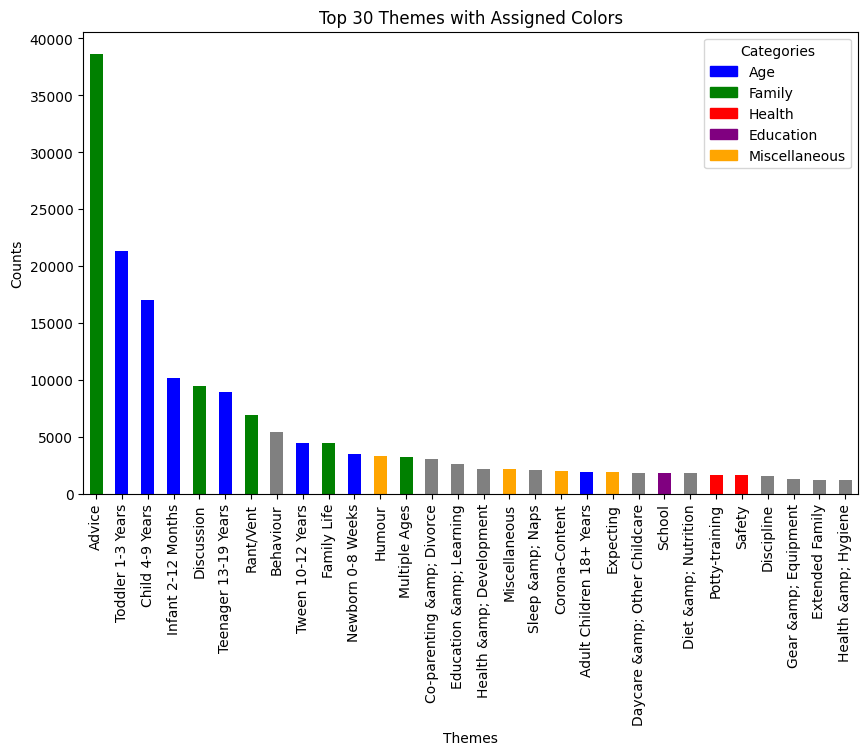

In [190]:
# Group themes into broader categories
theme_groups = {
    'Age': ['Newborn 0-8 Weeks', 'Infant 2-12 Months', 'Toddler 1-3 Years', 'Child 4-9 Years', 'Tween 10-12 Years', 'Teenager 13-19 Years', 'Adult Children 18+ Years'],
    'Family': ['Family Life', 'Co-parenting & Divorce', 'Advice', 'Discussion', 'Rant/Vent', 'Multiple Ages'],
    'Health': ['Health & Development', 'Sleep', 'Diet & Nutrition', 'Safety', 'Potty-training', 'Sleep & Naps'],
    'Education': ['Education & Learning', 'School'],
    'Miscellaneous': ['Humour', 'Miscellaneous', 'Corona-Content', 'Expecting']
}

# Assign colors to each category
colors = {
    'Age': 'blue',
    'Family': 'green',
    'Health': 'red',
    'Education': 'purple',
    'Miscellaneous': 'orange'
}

# Create a dictionary to store the color for each theme
theme_colors = {}
for category, themes_list in theme_groups.items():
    color = colors[category]
    for theme in themes_list:
        theme_colors[theme] = color

value_counts = df['link_flair_text'].value_counts().head(30)

def generate_bar_plot(value_counts, theme_colors):
    # Get the colors for the top 30 themes
    bar_colors = [theme_colors.get(theme, 'gray') for theme in value_counts.index]

    # Plot the bar chart
    plt.figure(figsize=(10, 6))
    value_counts.plot(kind='bar', color=bar_colors)
    plt.xlabel('Themes')
    plt.ylabel('Counts')
    plt.title('Top 30 Themes with Assigned Colors')
    # Create custom legend handles
    legend_handles = [Patch(color=color, label=category) for category, color in colors.items()]

    # Add the legend to the plot
    plt.legend(handles=legend_handles, title='Categories')

    plt.show()

generate_bar_plot(value_counts, theme_colors)

### Compare the sentiment distribution of the Age categories

In [191]:
age_df = df[df['link_flair_text'].apply(lambda x: x in theme_groups['Age']) ]
age_df['text'] = age_df['title'] + ' ' + age_df['selftext']
age_df = age_df.dropna(subset=['text'])
age_df

title  \
109581                               Trouble with napping   
109625         Just a rant about kids and social media...   
109645  How do you handle your daughter's first boyfri...   
109696                    Posting on behalf of my parents   
109747                   Traumatized our 2yr old toddler?   
...                                                   ...   
338244                     Son not respecting house rules   
338255         Help with expectations for picky eater....   
338256                                        Feeling bad   
338258                                            Daycare   
338259                       Teen/preteen boys’ sleepover   

                                                 selftext  \
109581  Hello all! I was hoping for some advice or tip...   
109625                                          [deleted]   
109645  So, yesterday after picking-up my kids from pr...   
109696                                          [removed]   
109747  We have a 2.5-year-old who's been described as...   
...                                                   ...   
338244                                          [removed]   
338255  Ok, so parents of picky eaters, I need some ad...   
338256  I am in so much guilt for not celebrating my y...   
338258  I want to preface this by saying that I unders...   
338259                                          [deleted]   

             link_flair_text  score  ups  downs num_comments  \
109581    Infant 2-12 Months    3.0  NaN    NaN            3   
109625  Teenager 13-19 Years    0.0  NaN    NaN            7   
109645       Child 4-9 Years    0.0  NaN    NaN           12   
109696  Teenager 13-19 Years    1.0  NaN    NaN            0   
109747     Toddler 1-3 Years   17.0  NaN    NaN           18   
...                      ...    ...  ...    ...          ...   
338244  Teenager 13-19 Years    1.0  NaN    NaN            0   
338255  Teenager 13-19 Years  121.0  NaN    NaN          123   
338256     Toddler 1-3 Years    0.0  NaN    NaN            7   
338258     Toddler 1-3 Years    0.0  NaN    NaN           10   
338259  Teenager 13-19 Years    9.0  NaN    NaN           43   

               created_utc                                               text  
109581 2018-01-01 01:42:36  Trouble with napping Hello all! I was hoping f...  
109625 2018-01-01 22:50:54  Just a rant about kids and social media... [de...  
109645 2018-01-02 04:17:08  How do you handle your daughter's first boyfri...  
109696 2018-01-02 23:37:18          Posting on behalf of my parents [removed]  
109747 2018-01-03 19:00:59  Traumatized our 2yr old toddler? We have a 2.5...  
...                    ...                                                ...  
338244 2022-12-31 21:35:20           Son not respecting house rules [removed]  
338255 2022-12-31 23:17:04  Help with expectations for picky eater.... Ok,...  
338256 2022-12-31 23:22:50  Feeling bad I am in so much guilt for not cele...  
338258 2022-12-31 23:37:00  Daycare I want to preface this by saying that ...  
338259 2022-12-31 23:37:05             Teen/preteen boys’ sleepover [deleted]  

[67314 rows x 9 columns]

In [192]:
from tqdm import tqdm
tqdm.pandas()

# sentiment analysis on cleaned selftext
import re
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk

# Download stopwords and punkt tokenizer from NLTK
nltk.download('stopwords')
nltk.download('punkt')

def clean_text(text):
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    text = text.replace('[removed]', '').replace('[deleted]', '')
    
    # Convert to lowercase
    text = text.lower()
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(text)
    filtered_text = [word for word in word_tokens if word not in stop_words]
    
    return ' '.join(filtered_text)

age_df['cleaned_text'] = age_df['text'].progress_apply(clean_text)

[nltk_data] Downloading package stopwords to /home/sarmad/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/sarmad/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
  0%|          | 0/67314 [00:00<?, ?it/s]

100%|██████████| 67314/67314 [00:30<00:00, 2182.24it/s]


In [193]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
vader_analyzer = SentimentIntensityAnalyzer()

def get_vader_sentiment(text):
    analysis = vader_analyzer.polarity_scores(text)
    return analysis['compound']

age_df['sentiment'] = age_df['cleaned_text'].progress_apply(get_vader_sentiment)

  0%|          | 0/67314 [00:00<?, ?it/s]

100%|██████████| 67314/67314 [00:54<00:00, 1242.34it/s]


In [6]:
# store the dataset in a csv file
# age_df.to_csv('age_groups_sentiment.csv', index=False)
age_df = pd.read_csv('age_groups_sentiment.csv')
age_df

title  \
0                                   Trouble with napping   
1             Just a rant about kids and social media...   
2      How do you handle your daughter's first boyfri...   
3                        Posting on behalf of my parents   
4                       Traumatized our 2yr old toddler?   
...                                                  ...   
67309                     Son not respecting house rules   
67310         Help with expectations for picky eater....   
67311                                        Feeling bad   
67312                                            Daycare   
67313                       Teen/preteen boys’ sleepover   

                                                selftext  \
0      Hello all! I was hoping for some advice or tip...   
1                                              [deleted]   
2      So, yesterday after picking-up my kids from pr...   
3                                              [removed]   
4      We have a 2.5-year-old who's been described as...   
...                                                  ...   
67309                                          [removed]   
67310  Ok, so parents of picky eaters, I need some ad...   
67311  I am in so much guilt for not celebrating my y...   
67312  I want to preface this by saying that I unders...   
67313                                          [deleted]   

            link_flair_text  score  ups  downs  num_comments  \
0        Infant 2-12 Months    3.0  NaN    NaN             3   
1      Teenager 13-19 Years    0.0  NaN    NaN             7   
2           Child 4-9 Years    0.0  NaN    NaN            12   
3      Teenager 13-19 Years    1.0  NaN    NaN             0   
4         Toddler 1-3 Years   17.0  NaN    NaN            18   
...                     ...    ...  ...    ...           ...   
67309  Teenager 13-19 Years    1.0  NaN    NaN             0   
67310  Teenager 13-19 Years  121.0  NaN    NaN           123   
67311     Toddler 1-3 Years    0.0  NaN    NaN             7   
67312     Toddler 1-3 Years    0.0  NaN    NaN            10   
67313  Teenager 13-19 Years    9.0  NaN    NaN            43   

               created_utc                                               text  \
0      2018-01-01 01:42:36  Trouble with napping Hello all! I was hoping f...   
1      2018-01-01 22:50:54  Just a rant about kids and social media... [de...   
2      2018-01-02 04:17:08  How do you handle your daughter's first boyfri...   
3      2018-01-02 23:37:18          Posting on behalf of my parents [removed]   
4      2018-01-03 19:00:59  Traumatized our 2yr old toddler? We have a 2.5...   
...                    ...                                                ...   
67309  2022-12-31 21:35:20           Son not respecting house rules [removed]   
67310  2022-12-31 23:17:04  Help with expectations for picky eater.... Ok,...   
67311  2022-12-31 23:22:50  Feeling bad I am in so much guilt for not cele...   
67312  2022-12-31 23:37:00  Daycare I want to preface this by saying that ...   
67313  2022-12-31 23:37:05             Teen/preteen boys’ sleepover [deleted]   

                                            cleaned_text  sentiment  
0      trouble napping hello hoping advice tips fourm...    -0.4653  
1                         rant kids social media deleted    -0.3400  
2      handle daughters first boyfriend preschool yes...     0.7133  
3                         posting behalf parents removed     0.0000  
4      traumatized 2yr old toddler 25yearold whos des...     0.7835  
...                                                  ...        ...  
67309                 son respecting house rules removed     0.4939  
67310  help expectations picky eater ok parents picky...     0.9490  
67311  feeling bad much guilt celebrating younger kid...     0.9260  
67312  daycare want preface saying understand sick ki...    -0.2928  
67313               teenpreteen boys ’ sleepover deleted     0.0000  

[67314 rows x 11 columns]

In [7]:
import numpy as np
from ridgeplot import ridgeplot

# Group themes into broader categories
theme_groups = {
    'Age': ['Newborn 0-8 Weeks', 'Infant 2-12 Months', 'Toddler 1-3 Years', 'Child 4-9 Years', 'Tween 10-12 Years', 'Teenager 13-19 Years', 'Adult Children 18+ Years'],
    'Family': ['Family Life', 'Co-parenting & Divorce', 'Advice', 'Discussion', 'Rant/Vent', 'Multiple Ages'],
    'Health': ['Health & Development', 'Sleep', 'Diet & Nutrition', 'Safety', 'Potty-training', 'Sleep & Naps'],
    'Education': ['Education & Learning', 'School'],
    'Miscellaneous': ['Humour', 'Miscellaneous', 'Corona-Content', 'Expecting']
}

# Assign colors to each category
colors = {
    'Age': 'blue',
    'Family': 'green',
    'Health': 'red',
    'Education': 'purple',
    'Miscellaneous': 'orange'
}


# Assuming the 'ridgeplot' library is already installed
# Aggregate the sentiment scores by link_flair_text

def generate_ridge_plot(samples, labels, kde_pts, title="Distribution of Sentiment Scores by Category", x_label="Sentiment Score", y_label="Category"):

    # Create the ridge plot
    fig = ridgeplot(
        samples=samples,
        labels=labels,
        coloralpha=0.95,
        bandwidth=0.3,  # Adjust bandwidth as necessary
        kde_points=kde_pts,
        spacing=0.33,
        linewidth=2,
    )
    # Customize the plot
    fig.update_layout(
        title=title,
        height=650,
        width=950,
        font_size=14,
        plot_bgcolor="rgb(245, 245, 245)",
        xaxis_gridcolor="white",
        yaxis_gridcolor="white",
        xaxis_gridwidth=2,
        yaxis_title=y_label,
        xaxis_title=x_label,
        showlegend=False,
    )
    # save the plot as a png file
    fig.write_image(f"plots/ridge_plot_{x_label.split(' ')[0]}.png")
    # Show the plot
    fig.show()

### Sentiment scores by age.
- Generate plots to find any patterns in the different categories
- Compare the documents for each age of high, neutral, and low sentiments to get a sense of the words associated with the sentiments
    - Get the sentiment dictionary to check for words with high/low scores in each category.
    - Look at some of the documents to get a sense of why there is a positive sentiment in younger ages.

In [8]:
categories = theme_groups['Age']
samples = [age_df[age_df['link_flair_text'] == link_flair_text]['sentiment'].values for link_flair_text in categories]
kde_pts = np.linspace(min(age_df['sentiment']) - 1, max(age_df['sentiment']) + 1, 400)
generate_ridge_plot(samples, categories, kde_pts, title="Distribution of Sentiment Scores by Category")

In [9]:
for category in categories:
    num_posts = 3
    print(f"Category: {category}")
    # print 5 posts with the highest sentiment scores and 5 posts with the lowest sentiment scores
    print("Posts with the highest sentiment scores:")
    postive_sentiment = age_df[age_df['link_flair_text'] == category].sort_values('sentiment', ascending=False).head(num_posts)[['title', 'selftext','sentiment']]
    for index, row in postive_sentiment.iterrows():
        print(f"Sentiment: {row['sentiment']}")
        print(f"Title: {row['title']}")
        print(f"Text: {row['selftext']}")
        print("\n")

    print("\nPosts with the lowest sentiment scores:")
    negative_sentiment = age_df[age_df['link_flair_text'] == category].sort_values('sentiment').head(num_posts)[['title', 'selftext','sentiment']]
    for index, row in negative_sentiment.iterrows():
        print(f"Sentiment: {row['sentiment']}")
        print(f"Title: {row['title']}")
        print(f"Text: {row['selftext']}")
        print("\n")
        print("------"*10)
    break

Category: Newborn 0-8 Weeks
Posts with the highest sentiment scores:
Sentiment: 0.9991
Title: If you are a new parent please read this about love and attachment
Text: I am a psychologist with a 5 month old son, and I am so sick of hearing all these Hollywood-myths about love and attachment that I believe are really unhealthy and create a lot of pressure for new parents, so please read this if you are a new parent struggling:

If you do not feel overwhelming love for your new born and/or if you did not feel euphoria at birth you are perfectly NORMAL / it is estimated that around 60% (!) do NOT feel overwhelming love and/or euphoria when they have a child and that is JUST FINE! You do NOT (necessarily) have PPD if you feel like this - you have PPD if you have a depression! Actually - some people with PPD do feel quite a strong connection with their children, so PPD is about being depressed, not about the amount of love you feel! 

Let me tell you why there is absolutely nothing wrong wit

### Other emotions
The max token length for emotion detector is 512 tokens. I am truncating entries greater than this length.
- For each emotion, plot a ridge plot to find patterns and explore documents to check if these patterns make sense.

In [10]:
# from transformers import AutoTokenizer, AutoModelForSequenceClassification
# from transformers import pipeline

# model_name = "bhadresh-savani/distilbert-base-uncased-emotion"
# tokenizer = AutoTokenizer.from_pretrained(model_name, max_length=512)
# model = AutoModelForSequenceClassification.from_pretrained(model_name)

# emotion_detector = pipeline(
#     "text-classification", 
#     model=model, 
#     tokenizer=tokenizer, 
#     return_all_scores=True,
#     padding=True, 
#     truncation=True, 
#     max_length=512
# )


# batch_size = 8
# texts = age_df['text'].tolist()
# results = []
# # Process the texts in batches with a progress bar
# for i in tqdm(range(0, len(texts), batch_size), desc="Processing Emotions"):
#     batch_texts = texts[i:i + batch_size]
#     batch_results = emotion_detector(batch_texts)
#     results.extend(batch_results)
# # add each emotion score as a column to the dataframe

In [11]:
# # Initialize columns for emotions
# emotion_list_dict = {}
# emotion_labels = ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']
# for label in emotion_labels:
#     emotion_list_dict[label] = []
#     age_df[label] = 0.0  # Initialize columns with 0.0

# # Add the emotion scores to the emotion_list dict
# for result in tqdm(results):
#     for i,label in enumerate(emotion_labels):
#         emotion_list_dict[label].append(result[i]['score'])
    

# # Add the emotion scores to the dataframe
# for label in emotion_labels:
#     age_df[label] = emotion_list_dict[label]


# age_df.to_csv('age_groups_sentiment_emotions.csv', index=False)
# age_df

In [12]:
age_df = pd.read_csv('age_groups_sentiment_emotions.csv')
age_df

title  \
0                                   Trouble with napping   
1             Just a rant about kids and social media...   
2      How do you handle your daughter's first boyfri...   
3                        Posting on behalf of my parents   
4                       Traumatized our 2yr old toddler?   
...                                                  ...   
67309                     Son not respecting house rules   
67310         Help with expectations for picky eater....   
67311                                        Feeling bad   
67312                                            Daycare   
67313                       Teen/preteen boys’ sleepover   

                                                selftext  \
0      Hello all! I was hoping for some advice or tip...   
1                                              [deleted]   
2      So, yesterday after picking-up my kids from pr...   
3                                              [removed]   
4      We have a 2.5-year-old who's been described as...   
...                                                  ...   
67309                                          [removed]   
67310  Ok, so parents of picky eaters, I need some ad...   
67311  I am in so much guilt for not celebrating my y...   
67312  I want to preface this by saying that I unders...   
67313                                          [deleted]   

            link_flair_text  score  ups  downs  num_comments  \
0        Infant 2-12 Months    3.0  NaN    NaN             3   
1      Teenager 13-19 Years    0.0  NaN    NaN             7   
2           Child 4-9 Years    0.0  NaN    NaN            12   
3      Teenager 13-19 Years    1.0  NaN    NaN             0   
4         Toddler 1-3 Years   17.0  NaN    NaN            18   
...                     ...    ...  ...    ...           ...   
67309  Teenager 13-19 Years    1.0  NaN    NaN             0   
67310  Teenager 13-19 Years  121.0  NaN    NaN           123   
67311     Toddler 1-3 Years    0.0  NaN    NaN             7   
67312     Toddler 1-3 Years    0.0  NaN    NaN            10   
67313  Teenager 13-19 Years    9.0  NaN    NaN            43   

               created_utc                                               text  \
0      2018-01-01 01:42:36  Trouble with napping Hello all! I was hoping f...   
1      2018-01-01 22:50:54  Just a rant about kids and social media... [de...   
2      2018-01-02 04:17:08  How do you handle your daughter's first boyfri...   
3      2018-01-02 23:37:18          Posting on behalf of my parents [removed]   
4      2018-01-03 19:00:59  Traumatized our 2yr old toddler? We have a 2.5...   
...                    ...                                                ...   
67309  2022-12-31 21:35:20           Son not respecting house rules [removed]   
67310  2022-12-31 23:17:04  Help with expectations for picky eater.... Ok,...   
67311  2022-12-31 23:22:50  Feeling bad I am in so much guilt for not cele...   
67312  2022-12-31 23:37:00  Daycare I want to preface this by saying that ...   
67313  2022-12-31 23:37:05             Teen/preteen boys’ sleepover [deleted]   

                                            cleaned_text  sentiment   sadness  \
0      trouble napping hello hoping advice tips fourm...    -0.4653  0.010990   
1                         rant kids social media deleted    -0.3400  0.801471   
2      handle daughters first boyfriend preschool yes...     0.7133  0.000498   
3                         posting behalf parents removed     0.0000  0.118002   
4      traumatized 2yr old toddler 25yearold whos des...     0.7835  0.125645   
...                                                  ...        ...       ...   
67309                 son respecting house rules removed     0.4939  0.032684   
67310  help expectations picky eater ok parents picky...     0.9490  0.007619   
67311  feeling bad much guilt celebrating younger kid...     0.9260  0.998992   
67312  daycare want preface saying understand sick ki... 

In [13]:
emotion_labels = ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']
for emotion in emotion_labels:
    categories = theme_groups['Age']
    samples = [age_df[age_df['link_flair_text'] == link_flair_text][emotion].values for link_flair_text in categories]
    print(len(samples))
    kde_pts = np.linspace(min(age_df[emotion]) - 1, max(age_df[emotion]) + 1, 400)
    emotion = emotion.capitalize()
    generate_ridge_plot(samples, categories, kde_pts, title=f"Distribution of {emotion} Scores by Age Groups", x_label=f"{emotion} Scores", y_label="Age Group")

7


7


7


7


7


7


In [14]:
embedding_model = SentenceTransformer('paraphrase-MiniLM-L6-v2')
embeddings = embedding_model.encode(age_df['selftext'], show_progress_bar=True)

Batches: 100%|██████████| 2104/2104 [02:57<00:00, 11.85it/s]


In [15]:
topic_models = {}
age_df['topic'] = np.nan
age_df['topic_prob'] = np.nan
for category in tqdm(categories):
    topic_models[category] = {}
    tqdm.write(f"Category: {category}")
    category_df = age_df[age_df['link_flair_text'] == category]
    category_embeddings = embeddings[category_df.index]
    category_docs = category_df['selftext'].tolist()
    model = BERTopic(nr_topics=20, calculate_probabilities=True)
    topic_models[category]['model'] = model.fit(category_docs, category_embeddings)
    topics, probs = model.transform(category_docs, category_embeddings)
    topic_models[category]['topics'] = topics
    topic_models[category]['topic_probs'] = probs
    topic_models[category]['topic_labels'] = model.get_topic_freq().index.tolist()
    

  0%|          | 0/7 [00:00<?, ?it/s]

Category: Newborn 0-8 Weeks


 14%|█▍        | 1/7 [00:31<03:10, 31.72s/it]

Category: Infant 2-12 Months


 29%|██▊       | 2/7 [01:20<03:29, 41.83s/it]

Category: Toddler 1-3 Years


 43%|████▎     | 3/7 [05:22<08:53, 133.35s/it]

Category: Child 4-9 Years


 57%|█████▋    | 4/7 [08:50<08:07, 162.51s/it]

Category: Tween 10-12 Years


 71%|███████▏  | 5/7 [09:04<03:38, 109.12s/it]

Category: Teenager 13-19 Years


 86%|████████▌ | 6/7 [10:14<01:35, 95.73s/it] 

Category: Adult Children 18+ Years


100%|██████████| 7/7 [10:27<00:00, 89.60s/it]


In [24]:
len(topic_models[category]['topic_probs'][:])

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [31]:
# get topic keywords


[('deleted', 1.8201458949165734),
 ('removed', 1.7618778695520922),
 ('step', 0.01107156338059338),
 ('item', 0.005191628112868934),
 ('scenario', 0.0037140527560716122),
 ('acceptance', 0.002280103195212304),
 ('cry', 0.0021023067732665853),
 ('from', 0.002045735276844563),
 ('deny', 0.0019258784717670458),
 ('receive', 0.0019258784717670458)]

In [25]:
for category in tqdm(categories):
    max_probs = [max(sublist) for sublist in topic_models[category]['topic_probs']]
    age_df.loc[age_df['link_flair_text'] == category, 'topic'] = topic_models[category]['topics']
    age_df.loc[age_df['link_flair_text'] == category, 'topic_prob'] = max_probs

age_df

100%|██████████| 7/7 [00:00<00:00, 30.36it/s]


title  \
0                                   Trouble with napping   
1             Just a rant about kids and social media...   
2      How do you handle your daughter's first boyfri...   
3                        Posting on behalf of my parents   
4                       Traumatized our 2yr old toddler?   
...                                                  ...   
67309                     Son not respecting house rules   
67310         Help with expectations for picky eater....   
67311                                        Feeling bad   
67312                                            Daycare   
67313                       Teen/preteen boys’ sleepover   

                                                selftext  \
0      Hello all! I was hoping for some advice or tip...   
1                                              [deleted]   
2      So, yesterday after picking-up my kids from pr...   
3                                              [removed]   
4      We have a 2.5-year-old who's been described as...   
...                                                  ...   
67309                                          [removed]   
67310  Ok, so parents of picky eaters, I need some ad...   
67311  I am in so much guilt for not celebrating my y...   
67312  I want to preface this by saying that I unders...   
67313                                          [deleted]   

            link_flair_text  score  ups  downs  num_comments  \
0        Infant 2-12 Months    3.0  NaN    NaN             3   
1      Teenager 13-19 Years    0.0  NaN    NaN             7   
2           Child 4-9 Years    0.0  NaN    NaN            12   
3      Teenager 13-19 Years    1.0  NaN    NaN             0   
4         Toddler 1-3 Years   17.0  NaN    NaN            18   
...                     ...    ...  ...    ...           ...   
67309  Teenager 13-19 Years    1.0  NaN    NaN             0   
67310  Teenager 13-19 Years  121.0  NaN    NaN           123   
67311     Toddler 1-3 Years    0.0  NaN    NaN             7   
67312     Toddler 1-3 Years    0.0  NaN    NaN            10   
67313  Teenager 13-19 Years    9.0  NaN    NaN            43   

               created_utc                                               text  \
0      2018-01-01 01:42:36  Trouble with napping Hello all! I was hoping f...   
1      2018-01-01 22:50:54  Just a rant about kids and social media... [de...   
2      2018-01-02 04:17:08  How do you handle your daughter's first boyfri...   
3      2018-01-02 23:37:18          Posting on behalf of my parents [removed]   
4      2018-01-03 19:00:59  Traumatized our 2yr old toddler? We have a 2.5...   
...                    ...                                                ...   
67309  2022-12-31 21:35:20           Son not respecting house rules [removed]   
67310  2022-12-31 23:17:04  Help with expectations for picky eater.... Ok,...   
67311  2022-12-31 23:22:50  Feeling bad I am in so much guilt for not cele...   
67312  2022-12-31 23:37:00  Daycare I want to preface this by saying that ...   
67313  2022-12-31 23:37:05             Teen/preteen boys’ sleepover [deleted]   

                                            cleaned_text  sentiment   sadness  \
0      trouble napping hello hoping advice tips fourm...    -0.4653  0.010990   
1                         rant kids social media deleted    -0.3400  0.801471   
2      handle daughters first boyfriend preschool yes...     0.7133  0.000498   
3                         posting behalf parents removed     0.0000  0.118002   
4      traumatized 2yr old toddler 25yearold whos des...     0.7835  0.125645   
...                                                  ...        ...       ...   
67309                 son respecting house rules removed     0.4939  0.032684   
67310  help expectations picky eater ok parents picky...     0.9490  0.007619   
67311  feeling bad much guilt celebrating younger kid...     0.9260  0.998992   
67312  daycare want preface saying understand sick ki... 

In [35]:
# for each topic, get the top 2 posts with the highest probability
# categories = theme_groups['Age']
categories = theme_groups['Age'][:3]
for category in categories:
    print(f"Category: {category}, Number of Posts: {len(age_df[age_df['link_flair_text'] == category])}")
    for topic in range(20):
        print(topic_models[category]['model'].get_topic(topic))
        print(f"Topic: {topic}")
        topic_df = age_df[(age_df['link_flair_text'] == category) & (age_df['topic'] == topic)].sort_values('topic_prob', ascending=False).head(5)
        for index, row in topic_df.iterrows():
            print(f"Title: {row['title']}")
            print(f"Text: {row['selftext']}")
            print(f"Topic Probability: {row['topic_prob']}")
            print("\n")
        print("------"*10)

Category: Newborn 0-8 Weeks, Number of Posts: 3478
[('removed', 4.813474877485854), ('', 1e-05), ('', 1e-05), ('', 1e-05), ('', 1e-05), ('', 1e-05), ('', 1e-05), ('', 1e-05), ('', 1e-05), ('', 1e-05)]
Topic: 0
Title: Absolutely infuriating
Text: [removed]
Topic Probability: 0.9999999989688627


Title: What do you think of the name Rea Alanna King
Text: [removed]
Topic Probability: 0.9999999989688627


Title: DOES ANYONE SWADDLE ANYMORE? Do you use muslin blankets?
Text: [removed]
Topic Probability: 0.9999999989688627


Title: The Fastest and safest way to get your baby to sleep
Text: [removed]
Topic Probability: 0.9999999989688627


Title: Newborn suddenly stopped taking breastmilk?
Text: [removed]
Topic Probability: 0.9999999989688627


------------------------------------------------------------
[('deleted', 5.493681728509168), ('', 1e-05), ('', 1e-05), ('', 1e-05), ('', 1e-05), ('', 1e-05), ('', 1e-05), ('', 1e-05), ('', 1e-05), ('', 1e-05)]
Topic: 1
Title: Did you use a doula, and 

### Treat the link flair text as a category. Model topics in each category and compare across categories
1. What types of discussions happen for each of the age groups? (Newborn, Infants, Toddlers, Child, Tween, Teen, Teenager etc.)